# Setup

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from __future__ import annotations

from utils import Stopwatch, chunksof

## Timing

In [2]:
stopwatch = Stopwatch()
stopwatch.start()

# Day 1

## Process input

In [3]:
with open('inputs/01') as f:
    chunks = f.read().rstrip().split('\n\n')
cals = [sum(int(n) for n in c.splitlines()) for c in chunks]

## Part 1

In [4]:
print(max(cals))
stopwatch.add_split()

74394


## Part 2

In [5]:
print(sum(sorted(cals)[-3:]))
stopwatch.add_split()

212836


# Day 2

## Process input

In [6]:
mapping = {
    'A': 0, 'B': 1, 'C': 2,
    'X': 0, 'Y': 1, 'Z': 2,
}

with open('inputs/02') as f:
    rounds = [(mapping[a], mapping[b]) for a, b in (line.strip().split() for line in f)]

## Part 1

In [7]:
succ = lambda a: (a + 1) % 3
pred = lambda a: (a - 1) % 3
    
def score_round(a, b):
    if a == b:
        return b + 4
    elif b == succ(a):
        return b + 7
    else:
        return b + 1

print(sum(score_round(*x) for x in rounds))
stopwatch.add_split()

9241


## Part 2

In [8]:
def score_round(a, b):
    if b == 0:
        return pred(a) + 1
    elif b == 1:
        return a + 4
    else:
        return succ(a) + 7

print(sum(score_round(*x) for x in rounds))
stopwatch.add_split()

14610


# Day 3

## Process input

In [9]:
def to_sack(contents):
    n = len(contents)
    assert n % 2 == 0
    i = n//2
    return set(contents[:i]), set(contents[i:])

with open('inputs/03') as f:
    sacks = [to_sack(line.rstrip()) for line in f]

## Part 1

In [10]:
def priority(item):
    if 'a' <= item <= 'z':
        return ord(item) - ord('a') + 1
    else:
        return ord(item) - ord('A') + 27

print(sum(priority(*(a & b)) for a, b in sacks))
stopwatch.add_split()

7824


## Part 2

In [11]:
merged = (a | b for a, b in sacks)
groups = chunksof(3, merged)
badges = (a & b & c for a, b, c in groups)
print(sum(priority(*b) for b in badges))
stopwatch.add_split()

2798


# Day 4

## Process input

In [12]:
def parse_range(r):
    start, end = r.split('-')
    return int(start), int(end)

def parse_row(r):
    a, b = r.rstrip().split(',')
    return parse_range(a), parse_range(b)

with open('inputs/04') as f:
    pairs = [parse_row(r) for r in f]

## Part 1

In [13]:
def intersect(a, b):
    (x, y) = a
    (z, w) = b
    overlap = x <= w and y >= z
    if overlap:
        return (max(x, z), min(y, w))
    else:
        return None

def fully_contained(a, b):
    x = intersect(a, b)
    return a == x or b == x

print(sum(1 for a, b in pairs if fully_contained(a, b)))
stopwatch.add_split()

498


## Part 2

In [14]:
print(sum(1 for a, b in pairs if intersect(a, b) != None))
stopwatch.add_split()

859


# Day 5

## Process input

In [15]:
def parse_container_line(s):
    containers = []
    for i, j in enumerate(range(1, len(s), 4)):
        if s[j] == ' ':
            continue
        containers.append((i, s[j]))
    return containers

def parse_command_line(s):
    parts = s.split()
    return int(parts[1]), int(parts[3]) - 1, int(parts[5]) - 1

with open('inputs/05') as f:
    container_string, command_string = f.read().rstrip().split('\n\n')

container_lines = container_string.split('\n')
command_lines = command_string.split('\n')

num_stacks = len(container_lines[-1].strip().split())
stacks = [[] for _ in range(num_stacks)]
for line in reversed(container_lines[:-1]):
    for stack, container in parse_container_line(line):
        stacks[stack].append(container)

commands = [parse_command_line(l) for l in command_lines]

## Part 1

In [16]:
def apply(command, stacks):
    num, src, dst = command
    for _ in range(num):
        stacks[dst].append(stacks[src].pop())

stacks_copy = [s.copy() for s in stacks]
for c in commands:
    apply(c, stacks_copy)
    
print(''.join(s[-1] for s in stacks_copy))
stopwatch.add_split()

TPGVQPFDH


## Part 2

In [17]:
def apply(command, stacks):
    num, src, dst = command
    stacks[dst] += stacks[src][-num:]
    del stacks[src][-num:]

stacks_copy = [s.copy() for s in stacks]
for c in commands:
    apply(c, stacks_copy)
    
print(''.join(s[-1] for s in stacks_copy))
stopwatch.add_split()

DMRDFRHHH


# Day 6

## Process input

In [18]:
with open('inputs/06') as f:
    signal = f.read().rstrip()

## Part 1

In [19]:
def marker_index(num_chars, signal):
    for i in range(0, len(signal)-num_chars):
        j = i + num_chars
        if len(set(signal[i:j])) == num_chars:
            return j
        
    assert False, "A signal start was not found"

print(marker_index(4, signal))
stopwatch.add_split()

1794


## Part 2

In [20]:
print(marker_index(14, signal))
stopwatch.add_split()

2851


# Day 7

## Process input

In [21]:
@dataclass
class Directory:
    name: str
    contents: dict[str, Node]
    
    def __eq__(self, other):
        return self.name == other.name

@dataclass
class File:
    name: str
    size: int
    
    def __eq__(self, other):
        return self.name == other.name

Node = Directory | File

def parse_node(s):
    match s.split():
        case ["dir", name]:
            return Directory(name, {})
        case [size, name]:
            return File(name, int(size))

with open('inputs/07') as f:
    blocks = [b.strip().split('\n') for b in f.read().split('$')[1:]]

root = Directory('root', {})
current = root
history = []
for cmd, *output in blocks:
    match cmd.split():
        case ['cd', '/']:
            current = root
            history = []
        case ['cd', '..']:
            current = history.pop()
        case ['cd', dst]:
            history.append(current)
            current = current.contents[dst]
        case ['ls']:
            nodes = (parse_node(s) for s in output)
            current.contents = {n.name: n for n in nodes}

## Part 1

In [22]:
def dirsizes(directory):
    self_size = 0
    sizes = []
    for node in directory.contents.values():
        match node:
            case File(_, sz):
                self_size += sz
            case Directory(_, _):
                sizes += dirsizes(node)
                self_size += sizes[-1]
    sizes.append(self_size)
    return sizes

ds = dirsizes(root)
print(sum(sz for sz in ds if sz <= 100_000))
stopwatch.add_split()

1453349


## Part 2

In [23]:
min_del_size = 30_000_000 - (70_000_000 - ds[-1])

print(min(sz for sz in ds if sz >= min_del_size))
stopwatch.add_split()

2948823


# Day X

## Process input

## Part 1

## Part 2

# Performance analysis

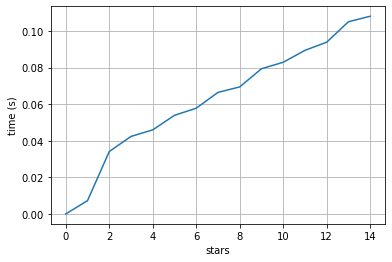

In [24]:
t = np.array(stopwatch.stop(add_split=False), dtype=int)
plt.plot(np.arange(len(t)), t / 1e9)
plt.xlabel('stars')
plt.ylabel('time (s)')
plt.grid('on')
plt.show()